### Target:
    - Check if varying the dropout rates improve training and validation accuracy 
    - Hit the target validation accuracy (99.40 %) at least once.
    
### Result :
    - Maximum Training Accuracy :- 99.178% (15th epoch) 
    - Maximum Validation Accuracy :- 99.40 (15th epoch) 
    - Final Parameter Count :- 7384
    
### Analysis :
     - Reducing the dropout rates improved both the training and validation accuracy. 
     - The model validation accuracy jumps around towards the second half of the training. Reducing LR with epoch might help
       improve model performance

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline



In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.mnist_classifier = nn.Sequential(
            nn.Conv2d(1, 8, 3, bias=False), # RF = 3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 16, 3, bias=False), # RF = 5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2), # RF = 6
            nn.Dropout(0.1),
            nn.Conv2d(16, 16, 3, bias=False), # RF = 10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3, bias=False), # RF = 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2), # RF = 16
            nn.Dropout(0.1),
            nn.Conv2d(16, 10, 3, bias=False), # RF = 24
            nn.AvgPool2d(2)
            

            
        )
    
    
    def forward(self, x):
        x = self.mnist_classifier(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         MaxPool2d-8           [-1, 16, 12, 12]               0
           Dropout-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

In [11]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([

                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [12]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):

    model.train()
    correct_train = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        train_pred = output.argmax(dim = 1,keepdim = True)
        correct_train += train_pred.eq(target.view_as(train_pred)).sum().item()
        
        for param in optimizer.param_groups:
          lr = param['lr']
        pbar.set_description(desc= f'epoch = {epoch + 1} loss={loss.item()} batch_id={batch_idx} learning_rate={lr} train_accuracy={correct_train * 100.0/len(train_loader.dataset)}')
    train_acc.append(correct_train * 100.0/len(train_loader.dataset))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


epoch = 1 loss=0.03312373533844948 batch_id=468 learning_rate=0.01 train_accuracy=96.07666666666667: 100%|█| 469/469 [0
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9868/10000 (99%)

EPOCH: 2


epoch = 2 loss=0.00835084356367588 batch_id=468 learning_rate=0.01 train_accuracy=98.26833333333333: 100%|█| 469/469 [0
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9889/10000 (99%)

EPOCH: 3


epoch = 3 loss=0.0496964156627655 batch_id=468 learning_rate=0.01 train_accuracy=98.52833333333334: 100%|█| 469/469 [00
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9851/10000 (99%)

EPOCH: 4


epoch = 4 loss=0.06853722780942917 batch_id=468 learning_rate=0.01 train_accuracy=98.615: 100%|█| 469/469 [00:10<00:00,
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9911/10000 (99%)

EPOCH: 5


epoch = 5 loss=0.010522227734327316 batch_id=468 learning_rate=0.01 train_accuracy=98.74166666666666: 100%|█| 469/469 [
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9901/10000 (99%)

EPOCH: 6


epoch = 6 loss=0.002988530322909355 batch_id=468 learning_rate=0.01 train_accuracy=98.84: 100%|█| 469/469 [00:10<00:00,
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99%)

EPOCH: 7


epoch = 7 loss=0.007288830354809761 batch_id=468 learning_rate=0.01 train_accuracy=98.88833333333334: 100%|█| 469/469 [
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99%)

EPOCH: 8


epoch = 8 loss=0.01446641143411398 batch_id=468 learning_rate=0.01 train_accuracy=98.93: 100%|█| 469/469 [00:10<00:00, 
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9904/10000 (99%)

EPOCH: 9


epoch = 9 loss=0.016337255015969276 batch_id=468 learning_rate=0.01 train_accuracy=98.97166666666666: 100%|█| 469/469 [
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99%)

EPOCH: 10


epoch = 10 loss=0.08937699347734451 batch_id=468 learning_rate=0.01 train_accuracy=99.045: 100%|█| 469/469 [00:10<00:00
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9919/10000 (99%)

EPOCH: 11


epoch = 11 loss=0.013620021753013134 batch_id=468 learning_rate=0.01 train_accuracy=99.10833333333333: 100%|█| 469/469 
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99%)

EPOCH: 12


epoch = 12 loss=0.06079762801527977 batch_id=468 learning_rate=0.01 train_accuracy=99.08166666666666: 100%|█| 469/469 [
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9920/10000 (99%)

EPOCH: 13


epoch = 13 loss=0.020124981179833412 batch_id=468 learning_rate=0.01 train_accuracy=99.11833333333334: 100%|█| 469/469 
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99%)

EPOCH: 14


epoch = 14 loss=0.004291383549571037 batch_id=468 learning_rate=0.01 train_accuracy=99.105: 100%|█| 469/469 [00:10<00:0
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99%)

EPOCH: 15


epoch = 15 loss=0.05343540385365486 batch_id=468 learning_rate=0.01 train_accuracy=99.17833333333333: 100%|█| 469/469 [



Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99%)



max train_acc: 99.17833333333333; max_test_acc : 99.4


Text(0.5, 1.0, 'Test Accuracy')

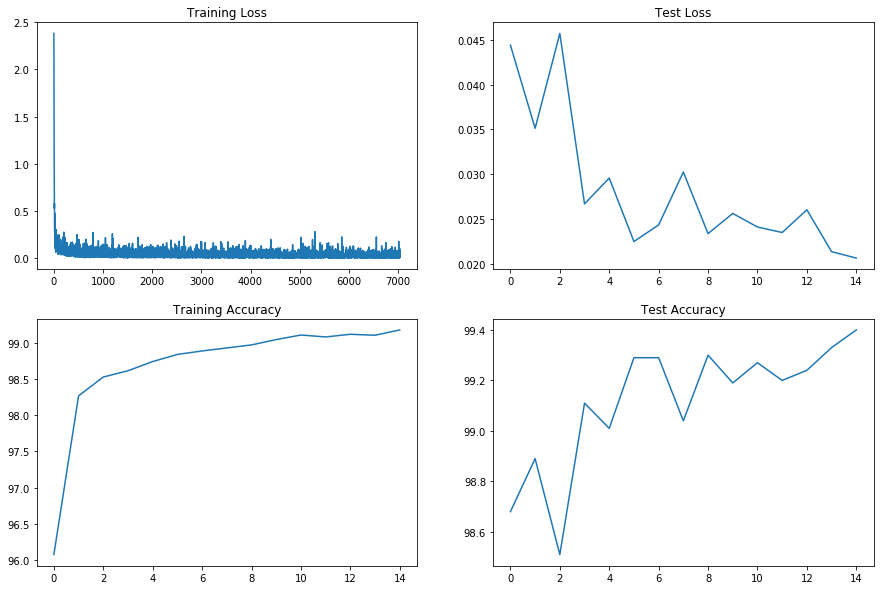

In [14]:

print(f'max train_acc: {max(train_acc)}; max_test_acc : {max(test_acc)}')

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")